# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
"""NIHCXR Clinical Drift Experiments Tutorial."""

from functools import partial

import numpy as np
from monai.transforms import Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device


device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-wIzUAwxh-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender",
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        Resized(
            keys=("features",), spatial_size=(224, 224), allow_missing_keys=True,
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        Lambdad(("features",), func=lambda x: np.mean(x, axis=0)[np.newaxis, np.newaxis, :] if x.shape[0] != 1 else x[np.newaxis, :], allow_missing_keys=True),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ],
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 76936.17 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 102019.98 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 118015.92 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 129643.12 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 137909.34 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 144761.62 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 116732.20 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 76706.08 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 108900.03 examples/s]

Filter (num_proc=6):  47%|████▋     | 52374/112120 [00:00<00:00, 106517.45 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 148795.85 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 150225.10 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 120408.96 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:02<00:01, 14.60 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 21.56 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 19.72 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.92 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.79 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 15.84 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 15.79 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.65 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.99 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.07 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.32 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.54 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 21.64 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 14.30 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 14.17 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.31 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.24 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.73 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.29 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 21.60 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.50 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.32 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.26 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.18 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.05 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.02 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.96 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.87 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.86 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.05 examples/s]

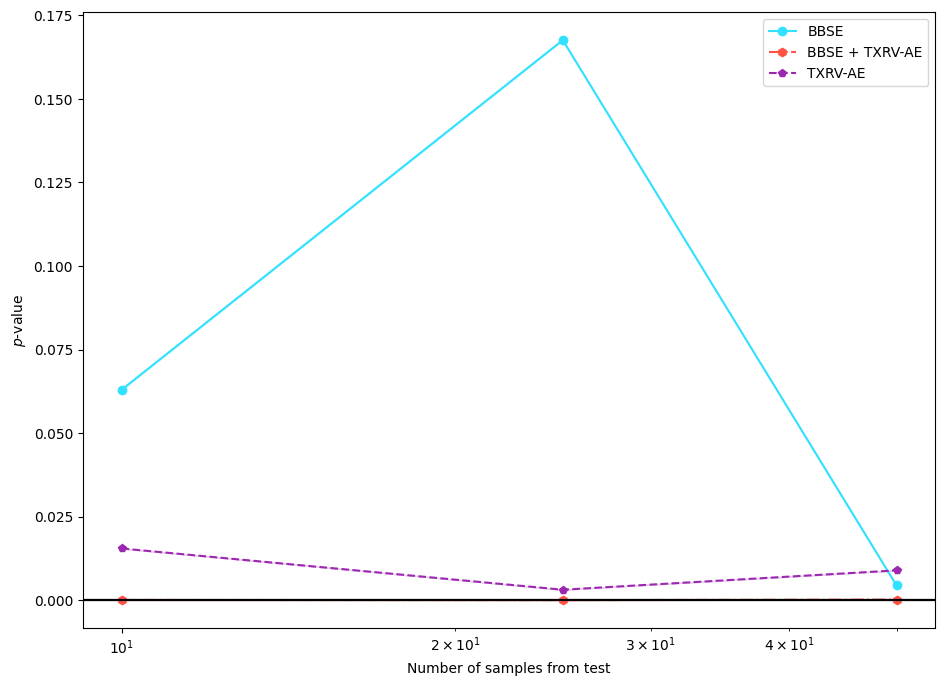

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="ks"),
        source_sample_size=50,
        target_sample_size=[10, 25, 50],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.68 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.55 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.49 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.62 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.50 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.99 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.93 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.85 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.03 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.16 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.62 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.58 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.49 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.28 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.13 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.28 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.21 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.85 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.07 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.19 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.43 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.14 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.11 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.34 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.21 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.22 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.15 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.11 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.64 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.67 examples/s]

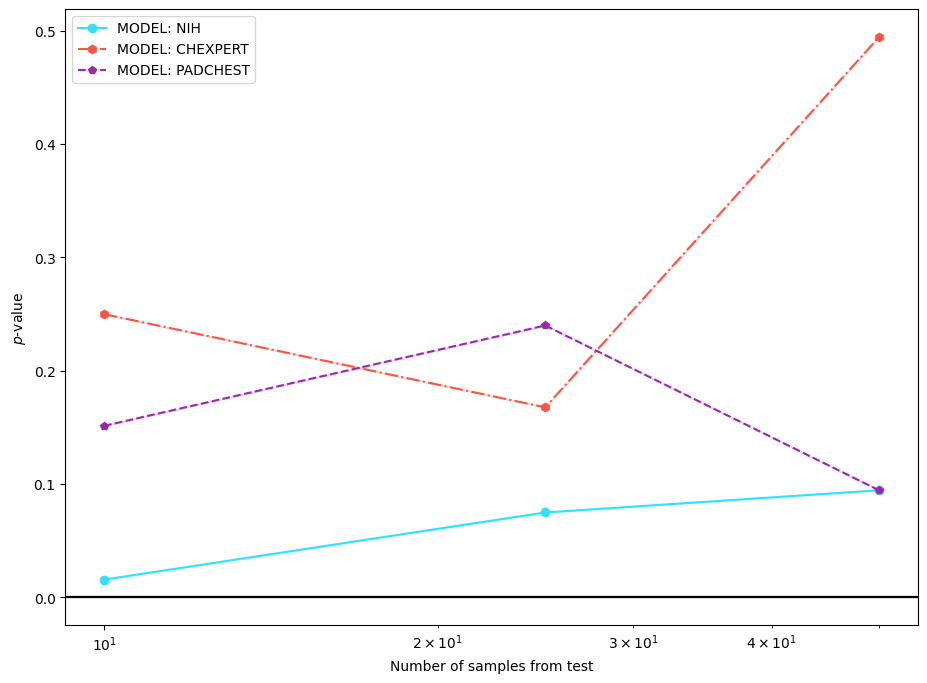

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device,
        ),
        tester=TSTester(tester_method="ks"),
        source_sample_size=50,
        target_sample_size=[10, 25, 50],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55448.19 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77888.94 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 88475.26 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 94063.42 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 97824.39 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 101437.43 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 83635.67 examples/s] 

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55495.89 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77875.31 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 92625.76 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 98504.98 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 102301.70 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 106487.28 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 86635.86 examples/s] 

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.51 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.52 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.40 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.28 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.14 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.76 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.69 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.63 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.05 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.10 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55067.89 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 76605.12 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 88072.70 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 95045.82 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 100174.07 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 103256.71 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 84271.65 examples/s] 

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 56946.02 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 78901.37 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 87926.41 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 90154.87 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 91224.93 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 94675.24 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 80299.61 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.40 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.18 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.14 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.16 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.02 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.98 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.92 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.95 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.11 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.25 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 56193.01 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77571.81 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 89778.71 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 96447.29 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 101294.61 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 104794.21 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 85788.75 examples/s] 

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 48950.63 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 68251.31 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 77146.06 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 84441.03 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 85774.31 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 92870.78 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 75680.10 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.41 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.30 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.23 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.41 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.26 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.10 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 17.03 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.15 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.63 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.67 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 50153.06 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 72232.46 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 85993.55 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 94142.93 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 98919.89 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 104973.71 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 83200.35 examples/s] 

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55504.15 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 72237.24 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 83347.96 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 87228.49 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 85978.71 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 92865.84 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 77737.03 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.69 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.59 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.51 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.09 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.95 examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.96 examples/s]

Map: 100%|██████████| 25/25 [00:01<00:00, 16.90 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.36 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.97 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 22.98 examples/s]

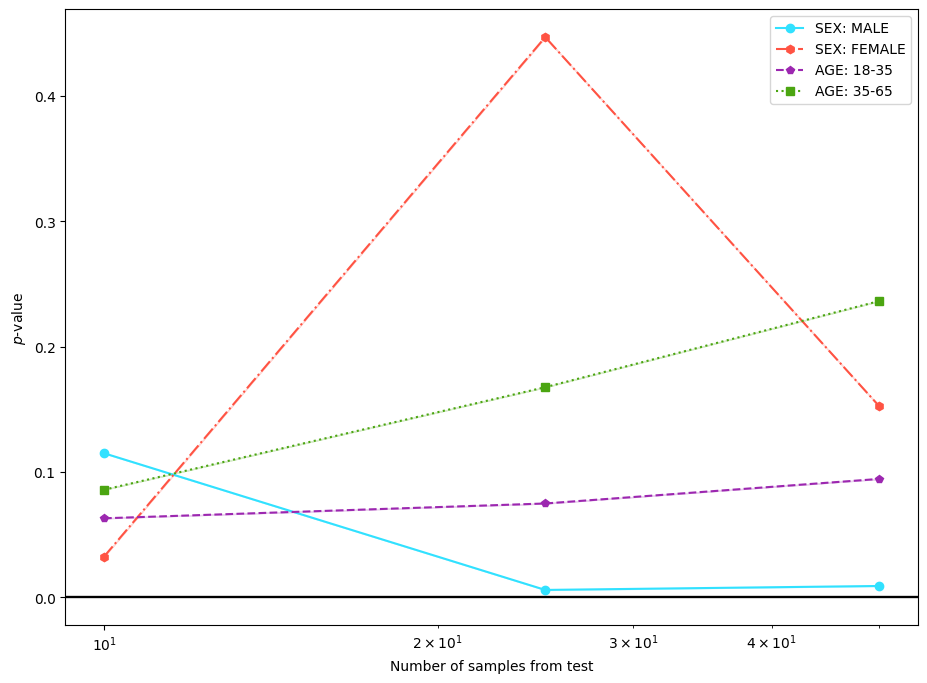

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}],
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}],
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice,
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="ks"),
        source_sample_size=50,
        target_sample_size=[10, 25, 50],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.62 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.52 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.44 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.55 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.40 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 12.91 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 12.82 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.92 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.78 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.64 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.51 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.61 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.48 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.00 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.86 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.08 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.94 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.12 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.98 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.98 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 15.84 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.26 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.12 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.38 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.26 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.32 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.18 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.23 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.09 examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.26 examples/s]

Map: 100%|██████████| 10/10 [00:00<00:00, 16.12 examples/s]

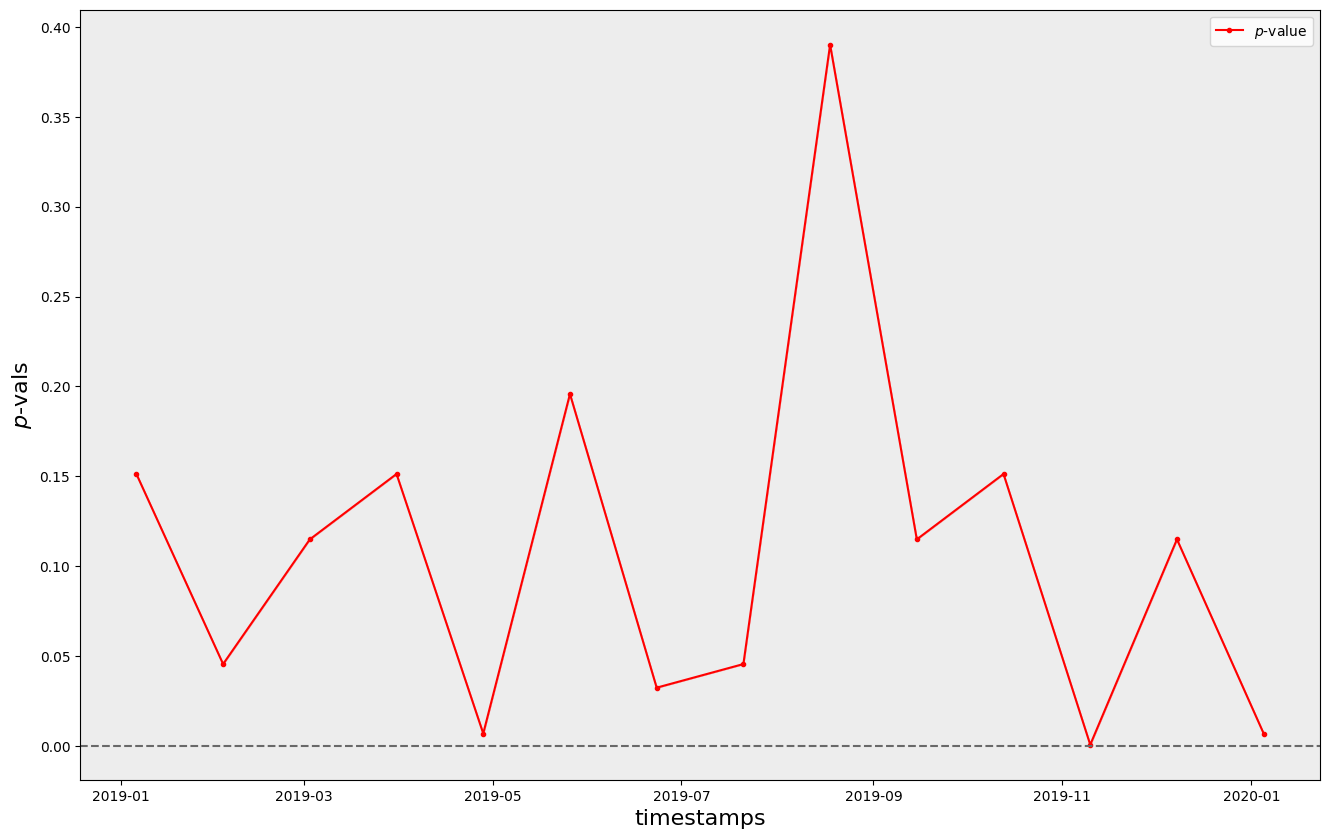

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="ks"),
    source_sample_size=50,
    target_sample_size=10,
    timestamp_column="timestamp",
    window_size="4W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)